# Imports

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Problem 1

## Part (a)

### Load in Fama French Portfolio Data

In [2]:
# Read the file, skipping header text rows and limiting to monthly data
ff = pd.read_csv("F-F_Research_Data_Factors 3.CSV", skiprows=3, nrows=1182)

# Rename the date column for clarity
ff.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert Date to string to extract Year and Month
ff['Date'] = ff['Date'].astype(str)
ff['Year'] = ff['Date'].str[:4].astype(int)
ff['Month'] = ff['Date'].str[4:].astype(int)

# Convert other values to floats
ff['Mkt-RF'] = ff['Mkt-RF'].astype(float)
ff['RF'] = ff['RF'].astype(float)

# Pull the columns we want
ff = ff[['Year', 'Month', 'Mkt-RF', 'RF']]

# Show the updated DataFrame
print(ff.head())


   Year  Month  Mkt-RF    RF
0  1926      7    2.96  0.22
1  1926      8    2.64  0.25
2  1926      9    0.36  0.23
3  1926     10   -3.24  0.32
4  1926     11    2.53  0.31


### Calculate Market Portfolio Statistics

In [3]:
# Compute market return
ff["Mkt"] = ff["Mkt-RF"] + ff["RF"]

# Compute average monthly return, volatility, and Sharpe ratio
mp_avg_return = ff["Mkt"].mean()
mp_volatility = ff["Mkt"].std()
mp_avg_excess_return = ff["Mkt-RF"].mean()
mp_sharpe_ratio = mp_avg_excess_return / mp_volatility

print(f"MP Average Monthly Return: {mp_avg_return:.4f}")
print(f"MP Volatility: {mp_volatility:.4f}")
print(f"MP Sharpe Ratio: {mp_sharpe_ratio:.4f}")

MP Average Monthly Return: 0.9557
MP Volatility: 5.3169
MP Sharpe Ratio: 0.1291


## Part (b)

### Load in Strategies Dataset

In [13]:
# Read the file
ss = pd.read_csv("ps1_strategies.csv")

# Convert Date to string to extract Year and Month
ss['date'] = ss['date'].astype(str)
ss['Year'] = ss['date'].str[:4].astype(int)
ss['Month'] = ss['date'].str[4:].astype(int)

# Make other values floats
ss['CA'] = ss['CA'].astype(float)
ss['LBHA'] = ss['LBHA'].astype(float)
ss['LSA'] = ss['LSA'].astype(float)
ss['TA'] = ss['TA'].astype(float)
ss['HV'] = ss['HV'].astype(float)
ss['LV'] = ss['LV'].astype(float)
ss['NA'] = ss['NA'].astype(float)
ss['LB'] = ss['LB'].astype(float)
ss['HB'] = ss['HB'].astype(float)

# Pull the columns we want
ss = ss[['Year', 'Month', 'CA', 'LBHA', 'LSA', 'TA', 'HV', 'LV', 'NA', 'LB', 
         'HB']]

# Show the updated DataFrame
print(ss.head())

   Year  Month        CA      LBHA     LSA        TA        HV        LV  \
0  1990      1 -1.771984  1.498262 -7.4575  1.679061 -7.271919  0.022091   
1  1990      2  1.418966  3.642659  1.0545  0.205289 -0.986167  0.062055   
2  1990      3  1.375007  1.737180  1.7385 -1.572688 -0.018665  0.341639   
3  1990      4 -0.395588  0.734520 -3.1920  2.474704 -3.294381  0.253568   
4  1990      5  2.588010  1.298923  7.9990  0.754379  8.038877 -0.113650   

         NA        LB         HB  
0 -5.392944 -1.353457 -22.772632  
1 -1.768405 -2.118514   5.151408  
2 -0.333926  1.452434   4.480134  
3 -2.578905  2.123740 -10.101798  
4  1.337511 -1.555230  26.259080  


### Merge the Datasets on Date

In [14]:
# Merge on Year and Month
merged = pd.merge(ss, ff, on=['Year', 'Month'], how='inner')

# Check merged result
print(merged.head())

   Year  Month        CA      LBHA     LSA        TA        HV        LV  \
0  1990      1 -1.771984  1.498262 -7.4575  1.679061 -7.271919  0.022091   
1  1990      2  1.418966  3.642659  1.0545  0.205289 -0.986167  0.062055   
2  1990      3  1.375007  1.737180  1.7385 -1.572688 -0.018665  0.341639   
3  1990      4 -0.395588  0.734520 -3.1920  2.474704 -3.294381  0.253568   
4  1990      5  2.588010  1.298923  7.9990  0.754379  8.038877 -0.113650   

         NA        LB         HB  Mkt-RF    RF   Mkt  
0 -5.392944 -1.353457 -22.772632   -7.85  0.57 -7.28  
1 -1.768405 -2.118514   5.151408    1.11  0.57  1.68  
2 -0.333926  1.452434   4.480134    1.83  0.64  2.47  
3 -2.578905  2.123740 -10.101798   -3.36  0.69 -2.67  
4  1.337511 -1.555230  26.259080    8.42  0.68  9.10  


### Calculate Constant Alpha Statistics

In [15]:
# First, find total returns from strategy
merged['CA_TR'] = merged["CA"] + merged["RF"]

# Then, compute average monthly return, volatility, and Sharpe ratio
ca_avg_return = merged['CA_TR'].mean()
ca_volatility = merged['CA_TR'].std()
ca_avg_excess_return = merged["CA"].mean()
ca_sharpe_ratio = ca_avg_excess_return / ca_volatility

print(f"CA Average Monthly Return: {ca_avg_return:.4f}")
print(f"CA Volatility: {ca_volatility:.4f}")
print(f"CA Sharpe Ratio: {ca_sharpe_ratio:.4f}")

CA Average Monthly Return: 0.9425
CA Volatility: 2.6183
CA Sharpe Ratio: 0.2803


## Part (c)

In [16]:
def estimate_capm(y):
    """
    Estimates CAPM alpha and beta for a given portfolio.

    Parameters:
        y : [pd.Series] The excess returns of the asset or strategy (i.e., 
                        asset return minus risk-free rate).

    Returns:
        dict: Contains alpha, beta, and regression summary.
    """
    # Set up regression: Excess_Portfolio ~ Market Excess Return (Mkt-RF)
    X = merged['Mkt-RF']

    X = sm.add_constant(X)  # Add intercept for alpha
    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    beta = model.params['Mkt-RF']

    return {
        'alpha': alpha,
        'beta': beta,
        'summary': model.summary(),
    }

## Part (d)

In [17]:
results = estimate_capm(merged['CA'])
print(f"Alpha: {results['alpha']:.4f}")
print(f"Beta: {results['beta']:.4f}")
print(results['summary'])

Alpha: 0.3980
Beta: 0.4887
                            OLS Regression Results                            
Dep. Variable:                     CA   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     866.8
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          1.17e-101
Time:                        22:47:29   Log-Likelihood:                -716.07
No. Observations:                 397   AIC:                             1436.
Df Residuals:                     395   BIC:                             1444.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3980    

## Part (e)

In [18]:
# Calculate CAPM-implied return for each time period
merged['CA_TR_hat'] = merged['RF'] + results['beta'] * merged['Mkt-RF']
print(merged.head())

   Year  Month        CA      LBHA     LSA        TA        HV        LV  \
0  1990      1 -1.771984  1.498262 -7.4575  1.679061 -7.271919  0.022091   
1  1990      2  1.418966  3.642659  1.0545  0.205289 -0.986167  0.062055   
2  1990      3  1.375007  1.737180  1.7385 -1.572688 -0.018665  0.341639   
3  1990      4 -0.395588  0.734520 -3.1920  2.474704 -3.294381  0.253568   
4  1990      5  2.588010  1.298923  7.9990  0.754379  8.038877 -0.113650   

         NA        LB         HB  Mkt-RF    RF   Mkt     CA_TR  CA_TR_hat  
0 -5.392944 -1.353457 -22.772632   -7.85  0.57 -7.28 -1.201984  -3.266388  
1 -1.768405 -2.118514   5.151408    1.11  0.57  1.68  1.988966   1.112470  
2 -0.333926  1.452434   4.480134    1.83  0.64  2.47  2.015007   1.534343  
3 -2.578905  2.123740 -10.101798   -3.36  0.69 -2.67  0.294412  -0.952072  
4  1.337511 -1.555230  26.259080    8.42  0.68  9.10  3.268010   4.794954  


## Part (f)

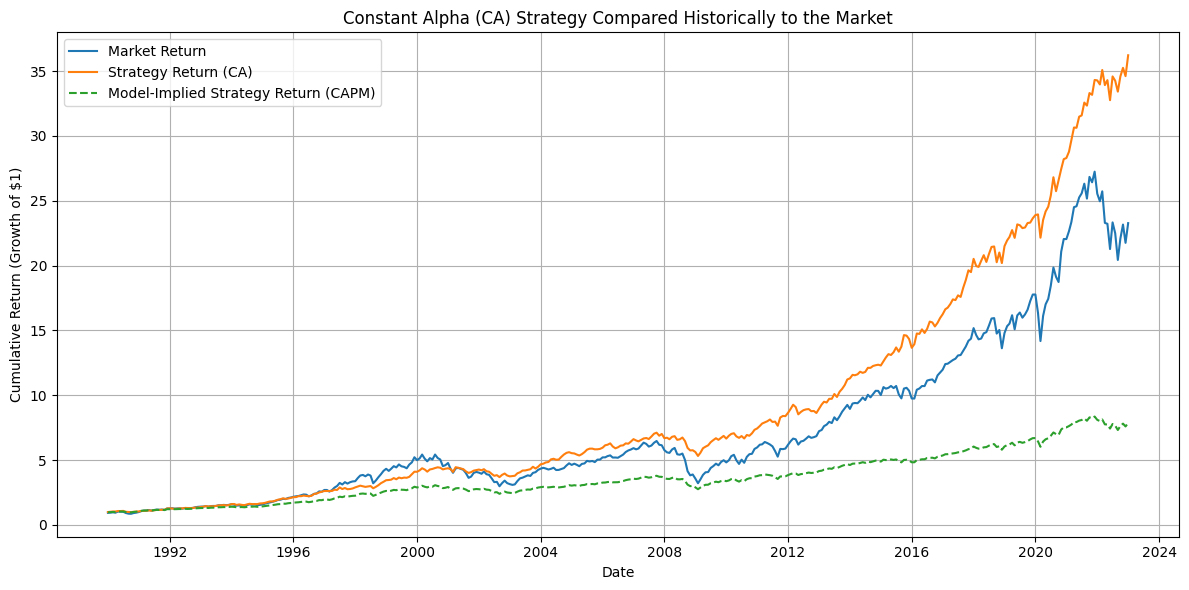

In [19]:
# Compute cumulative returns
# "If I invested $1 at the start and reinvested returns each month, how much 
# money would I have at each time point?"
# Convert from percentage returns to decimal returns
merged['Mkt_cum'] = (1 + merged['Mkt'] / 100).cumprod()
merged['TR_cum'] = (1 + merged['CA_TR'] / 100).cumprod()
merged['RP_hat_cum'] = (1 + merged['CA_TR_hat'] / 100).cumprod()

# Create time axis from Year and Month
merged['Date'] = pd.to_datetime(merged['Year'].astype(str) + 
                                 merged['Month'].astype(str).str.zfill(2), 
                                 format='%Y%m')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['Mkt_cum'], label='Market Return')
plt.plot(merged['Date'], merged['TR_cum'], label='Strategy Return (CA)')
plt.plot(merged['Date'], merged['RP_hat_cum'], 
         label='Model-Implied Strategy Return (CAPM)', linestyle='--')

plt.title('Constant Alpha (CA) Strategy Compared Historically to the Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Part (g)

Based on both the statistical analysis and the cumulative return plot, the CA strategy appears to be a compelling hedge fund candidate. While its average monthly return is similar to that of the market (0.9425% vs. 0.9557%), it achieves this performance with much lower volatility (2.62% vs. 5.32%), resulting in a significantly higher Sharpe ratio (0.2803 vs. 0.1291). This means the CA strategy delivers more return per unit of risk, a highly desirable trait in hedge fund management.

The regression results also highlight a relatively low beta of 0.4887, indicating that CA is less sensitive to market movements. Even more importantly, the strategy delivers a statistically significant alpha of 0.3980 (p-value of 0.000 < 0.05), suggesting it captures returns that the CAPM does not explain.

These findings are visually reinforced in the cumulative return plot. Over time, the CA strategy outpaces both the market and the model-implied returns by a wide margin, especially from around 2012 onward. This divergence shows that the strategy is not only consistent but also resilient, recovering quickly from drawdowns and compounding returns at a higher rate. In contrast, the CAPM-implied return grows much more slowly, underlining that the CA strategy’s performance cannot be fully explained by exposure to market risk alone.

In sum, the CA strategy’s strong risk-adjusted performance, positive alpha, and visual dominance in long-term growth **make it a good hedge fund strategy**.

# Problem 2

In [20]:
def analyze_strategy(strategy_name):
    """
    Analyze a strategy's performance using CAPM metrics and cumulative returns.

    Parameters:
    -----------
    strategy_name : str
        The name of the strategy column in the 'merged' DataFrame (e.g., "CA", 
        "LBHA").

    Returns:
    --------
    None. Prints results and plots cumulative returns.
    """
    # Calculate total return by adding back RF
    merged[f'{strategy_name}_TR'] = merged[strategy_name] + merged['RF']

    # Basic stats
    avg_return = merged[f'{strategy_name}_TR'].mean()
    volatility = merged[f'{strategy_name}_TR'].std()
    excess_mean = merged[strategy_name].mean()
    sharpe_ratio = excess_mean / volatility

    print(f"{strategy_name} Average Monthly Return: {avg_return:.4f}")
    print(f"{strategy_name} Volatility: {volatility:.4f}")
    print(f"{strategy_name} Sharpe Ratio: {sharpe_ratio:.4f}")

    # Run CAPM regression
    X = sm.add_constant(merged['Mkt-RF'])
    y = merged[strategy_name]
    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    beta = model.params['Mkt-RF']

    print(f"{strategy_name} Alpha: {alpha:.4f}")
    print(f"{strategy_name} Beta: {beta:.4f}")
    print(model.summary())

    # CAPM implied return
    merged[f'{strategy_name}_TR_hat'] = merged['RF'] + beta * merged['Mkt-RF']

    # Cumulative return calculations (convert % to decimals)
    merged['Mkt_cum'] = (1 + merged['Mkt'] / 100).cumprod()
    merged[f'{strategy_name}_cum'] = (1 + merged[f'{strategy_name}_TR'] / 
                                      100).cumprod()
    merged[f'{strategy_name}_hat_cum'] = (1 + merged[f'{strategy_name}_TR_hat'] 
                                          / 100).cumprod()

    # Create datetime column
    merged['Date'] = pd.to_datetime(
        merged['Year'].astype(str) + merged['Month'].astype(str).str.zfill(2),
        format='%Y%m'
    )

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(merged['Date'], merged['Mkt_cum'], label='Market Return')
    plt.plot(merged['Date'], merged[f'{strategy_name}_cum'], label=
             f'Strategy Return ({strategy_name})')
    plt.plot(merged['Date'], merged[f'{strategy_name}_hat_cum'], 
             label='Model-Implied Strategy Return (CAPM)', linestyle='--')

    plt.title(f'Cumulative Returns: Market vs {strategy_name} vs CAPM-Implied')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Growth of $1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Part (a)

LBHA Average Monthly Return: 0.6944
LBHA Volatility: 2.1102
LBHA Sharpe Ratio: 0.2303
LBHA Alpha: 0.4828
LBHA Beta: 0.0045
                            OLS Regression Results                            
Dep. Variable:                   LBHA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.03677
Date:                Fri, 11 Apr 2025   Prob (F-statistic):              0.848
Time:                        22:47:40   Log-Likelihood:                -854.63
No. Observations:                 397   AIC:                             1713.
Df Residuals:                     395   BIC:                             1721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

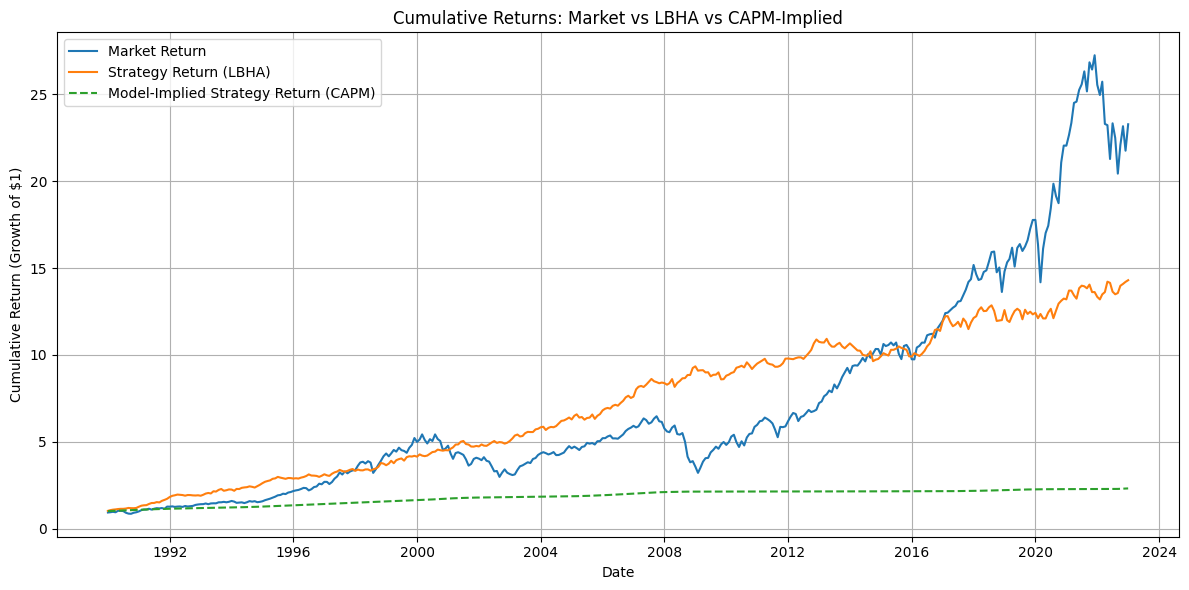

In [21]:
analyze_strategy("LBHA")

## Part (b)

## Part (c)